### Import packages for statistical analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.nonparametric.smoothers_lowess import lowess
from patsy import dmatrices

In [2]:
%matplotlib inline

### Load the Boston data set and check the columns

In [3]:
boston = sm.datasets.get_rdataset('Boston', 'MASS')
boston_df = boston.data

In [4]:
boston_df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


### Fit a simple linear regression model of `lstat` to `medv`

In [5]:
y, X = dmatrices('medv ~ lstat', data=boston_df, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()

Summary of the result of the regression:

In [6]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           5.08e-88
Time:                        12:50:05   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.0

Confidence intervals of the coefficients:

In [7]:
res.conf_int()

,0,1
Intercept,33.448457,35.659225
lstat,-1.026148,-0.873951


Predict `medv` for `lstat = [5, 10, 15]`:

In [8]:
res.predict([[1, 5], [1, 10], [1, 15]])

array([29.80359411, 25.05334734, 20.30310057])

Plot the data and regression line

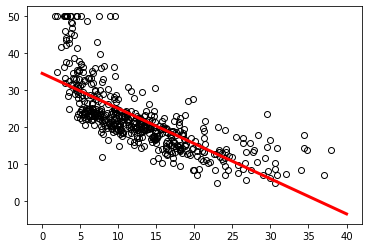

In [9]:
plt_num = 50
X_plot = np.stack([np.ones(plt_num), np.linspace(0, 40, num=plt_num)], axis=1)
plt.plot(X['lstat'], y, 'ko', markerfacecolor='none')
plt.plot(X_plot[:, 1], res.predict(X_plot), 'r', linewidth=3)
plt.show()

Create a $2 \times 2$ figure similar to running `par(mfrow=c(2,2))` and `plot(lm.fit)` in R

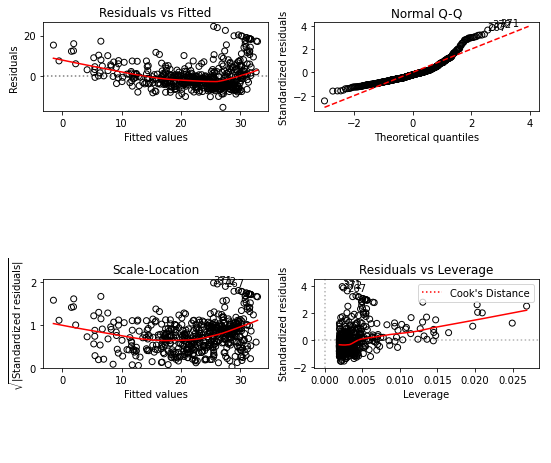

In [10]:
fig, ax = plt.subplots(2, 2, figsize=[8, 8])

### Create the Residuals vs. Fitted plot
residuals = res.resid
fitted = res.fittedvalues
smoothed = lowess(residuals, fitted)
top3 = abs(residuals).sort_values(ascending=False)[:3]

# Plot the values
ax[0, 0].scatter(fitted, residuals, edgecolors='k', facecolors='none')
ax[0, 0].plot(smoothed[:, 0], smoothed[:, 1], color='r')
ax[0, 0].axhline(0, color='k', linestyle=':', alpha=.5)
ax[0, 0].set_xlabel('Fitted values')
ax[0, 0].set_ylabel('Residuals')
ax[0, 0].set_title('Residuals vs Fitted')


### Create the Q-Q plot
sorted_student_residuals = pd.Series(
    res.get_influence().resid_studentized_internal)
sorted_student_residuals.index = res.resid.index
sorted_student_residuals = sorted_student_residuals.sort_values(
    ascending=True)
df = pd.DataFrame(sorted_student_residuals)
df.columns = ['sorted_student_residuals']
df['theoretical_quantiles'] = stats.probplot(
    df['sorted_student_residuals'], dist='norm', fit=False)[0]
rankings = abs(df['sorted_student_residuals']).sort_values(
    ascending=False)
top3 = rankings[:3]
x = df['theoretical_quantiles']
y = df['sorted_student_residuals']

# Plot the values
ax[0, 1].scatter(x, y, edgecolors='k', facecolors='none')
ax[0, 1].set_title('Normal Q-Q')
ax[0, 1].set_xlabel('Theoretical quantiles')
ax[0, 1].set_ylabel('Standardized residuals')
ax[0, 1].plot([np.min([x, y]), np.max([x, y])], 
              [np.min([x, y]), np.max([x, y])], color='r', ls='--')
for val in top3.index:
    ax[0, 1].annotate(val, xy=(
        df['theoretical_quantiles'].loc[val], 
        df['sorted_student_residuals'].loc[val]
    ))

    
### Create the Scale-Location plot
student_residuals = res.get_influence().resid_studentized_internal
sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
sqrt_student_residuals.index = res.resid.index
smoothed = lowess(sqrt_student_residuals, fitted)
top3 = abs(sqrt_student_residuals).sort_values(ascending=False)[:3]

# Plot the values
ax[1, 0].scatter(fitted, sqrt_student_residuals, 
                 edgecolors='k', facecolors='none')
ax[1, 0].plot(smoothed[:, 0], smoothed[:, 1], color='r')
ax[1, 0].set_xlabel('Fitted values')
ax[1, 0].set_ylabel('$\\sqrt{|\\mathrm{Standardized \ residuals}|}$')
ax[1, 0].set_title('Scale-Location')
ax[1, 0].set_ylim(0, max(sqrt_student_residuals) + 0.1)
for i in top3.index:
    ax[1, 0].annotate(i, xy=(fitted[i], sqrt_student_residuals[i]))

    
### Create the Residuals vs. Leverage plot
student_residuals = pd.Series(res.get_influence().resid_studentized_internal)
student_residuals.index = res.resid.index
df = pd.DataFrame(student_residuals)
df.columns = ['student_residuals']
df['leverage'] = res.get_influence().hat_matrix_diag
smoothed = lowess(df['student_residuals'], df['leverage'])
sorted_student_residuals = abs(df['student_residuals']).sort_values(ascending=False)
top3 = sorted_student_residuals[:3]

# Plot the values
x = df['leverage']
y = df['student_residuals']
xpos= max(x) + max(x) * 0.01
ax[1, 1].scatter(x, y, edgecolors='k', facecolors='none')
ax[1, 1].plot(smoothed[:, 0], smoothed[:, 1], color='r')
ax[1, 1].set_title('Residuals vs Leverage')
ax[1, 1].set_xlabel('Leverage')
ax[1, 1].set_ylabel('Standardized residuals')
ax[1, 1].set_ylim(min(y) - min(y) * 0.15, max(y) + max(y) * 0.15)
# ax[1, 1].set_xlim(-0.01, max(x) + max(x) * 0.05)
for val in top3.index:
    ax[1, 1].annotate(val, xy=(x.loc[val], y.loc[val]))
    
cooksx = np.linspace(min(x), xpos, 50)
p = len(res.params)
poscooks1y = np.sqrt((p * (1 - cooksx)) / cooksx)
poscooks05y = np.sqrt(0.5 * (p * (1 - cooksx)) / cooksx)
negcooks1y = -np.sqrt((p * (1 - cooksx)) / cooksx)
negcooks05y = -np.sqrt(0.5 * (p * (1 - cooksx)) / cooksx)

ax[1, 1].plot(cooksx, poscooks1y, label='Cook\'s Distance', ls=':', color='r')
ax[1, 1].plot(cooksx, poscooks05y, ls=':', color='r')
ax[1, 1].plot(cooksx, negcooks1y, ls=':', color='r')
ax[1, 1].plot(cooksx, negcooks05y, ls=':', color='r')
ax[1, 1].axvline(0, ls=':', alpha=.3, color='k')
ax[1, 1].axhline(0, ls=':', alpha=.3, color='k')
ax[1, 1].annotate('1.0', xy=(xpos, poscooks1y[-1]), color='r')
ax[1, 1].annotate('0.5', xy=(xpos, poscooks05y[-1]), color='r')
ax[1, 1].annotate('1.0', xy=(xpos, negcooks1y[-1]), color='r')
ax[1, 1].annotate('0.5', xy=(xpos, negcooks05y[-1]), color='r')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

### Multiple linear regression

Fit a linear regression model with `lstat` and `age`

In [11]:
y2, X2 = dmatrices('medv ~ lstat + age', data=boston_df, return_type='dataframe')
mod2 = sm.OLS(y2, X2)
res2 = mod2.fit()

In [12]:
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           2.98e-88
Time:                        12:50:07   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     33.2228      0.731     45.458      0.0

In [13]:
y3, X3 = dmatrices('medv ~ ' + ' + '.join(boston_df.columns[:-1]), 
                   data=boston_df, return_type='dataframe')
mod3 = sm.OLS(y3, X3)
res3 = mod3.fit()

In [14]:
print(res3.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Mon, 12 Jul 2021   Prob (F-statistic):          6.72e-135
Time:                        12:50:07   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.0

### Interaction terms

Model example with an interaction between `lstat` and `age`

In [15]:
yi, Xi = dmatrices('medv ~ lstat * age', data=boston_df, return_type='dataframe')
print(sm.OLS(yi, Xi).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     209.3
Date:                Mon, 12 Jul 2021   Prob (F-statistic):           4.86e-88
Time:                        12:50:07   Log-Likelihood:                -1635.0
No. Observations:                 506   AIC:                             3278.
Df Residuals:                     502   BIC:                             3295.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.0885      1.470     24.553      0.0

### Nonlinear transformations of predictors

In [16]:
yn, Xn = dmatrices('medv ~ lstat + I(lstat ** 2)', data=boston_df, return_type='dataframe')
print(sm.OLS(yn, Xn).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Mon, 12 Jul 2021   Prob (F-statistic):          1.56e-112
Time:                        12:50:07   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        42.8620      0.872     49.149